# Loan Completion Analysis
## by Jeff Mitchell

## Investigation Overview

The purpose of this analysis is to see what factors impact on the likelihood of a loan being completed. The main focus was on Loan completion and specific factors of the member and the loan that influenced loan completion.

## Dataset Overview

The dataset contains information on nearly 114,000 loans from Prosper. Only loans that had been conclcuded (Paid off succesfully or failed to be paid off) were used for the analysis, which reduced the sample number to 55076. There were loans that were missing values that could not be corrected which resulted in a further 591 loans being removed.

Attributes of interest included Loan completion status, BorrowerAPR, Debt-to-income ratio, Term, Loan Origination Quarter, Monthly Loan Payments and Employment status. There were 81 data points per loan, many of which were not relevant for this analysis. This number was reduced to 16 for the intial analysis.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loans = pd.read_csv('prosperLoanData.csv')

In [3]:
# prepare the data prior to analysis

# reduce the number of columns to just those that are of interest
columns = ['Term', 'LoanStatus', 'BorrowerAPR', 'ListingCategory (numeric)', 'EmploymentStatus', 'IsBorrowerHomeowner', 
           'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'LoanNumber',
           'LoanOriginalAmount', 'LoanOriginationQuarter', 'MemberKey', 'MonthlyLoanPayment']
loans = loans[columns]

# rename columns
loans = loans.rename(columns={'ListingCategory (numeric)':'ListingCategory','IsBorrowerHomeowner':'HomeOwner',})

# remove loans that have not reached an outcome
loans = loans[loans['LoanStatus'].isin(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'])]

# drop rows duplicated on LoanNumber
loans.drop_duplicates('LoanNumber', inplace=True)

In [4]:
# create LoanCompleted column

# Function to return loan completion status
def getLoanCompleted(loan_status):
    """Return 'Completed' if loan completed, 'Not completed' otherwise."""
    if loan_status.strip() == 'Completed':
        return 'Completed'
    else:
        return 'Not completed'
    
# Create column to hold status of loan outcome
loans['LoanCompleted'] = loans['LoanStatus'].apply(getLoanCompleted)
loans['LoanCompleted'] = loans['LoanCompleted'].astype('category')

# Drop LoanStatus column
loans.drop('LoanStatus', axis=1, inplace=True)

In [5]:
# convert column types

# Convert LoanNumber to a string as I will not perform calcluations on it
loans['LoanNumber'] = loans['LoanNumber'].astype('str')

# Convert the ListingCategory column to readable values
def convert_listing_category(cat):
    """Convert the listing category to a human-readable string."""
    categories = ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business', 'Personal Loan', 'Student Use',
                 'Auto', 'Other', 'Baby and Adoption', 'Boat', 'Cosmetic Procedure', 'Engagement Ring', 'Green Loans',
                 'Household Expenses', 'Large Purchases', 'Medical and Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                 'Wedding']
    return categories[cat]

loans['ListingCategory'] = loans['ListingCategory'].apply(convert_listing_category)

# Convert ListingCategory to categorical types
loans['ListingCategory'] = loans['ListingCategory'].astype('category')

# Convert null EmploymentStatus to 'Not available'
loans['EmploymentStatus'] = loans['EmploymentStatus'].fillna('Not available')

# Convert 'Employed' to 'Full-time'
mask = loans['EmploymentStatus'] == 'Employed'
column_name = 'EmploymentStatus'
loans.loc[mask, column_name] = 'Full-time'

# Convert EmploymentStatus to categorical type
loans['EmploymentStatus'] = loans['EmploymentStatus'].astype('category')

# Convert LoanOriginationQuarter to categorical type
loans['LoanOriginationQuarter'] = loans['LoanOriginationQuarter'].astype('category')

# Convert Term to categorical type
loans['Term'] = loans['Term'].astype('category')

# Function to calculate mean of lower and upper credit ratings
def get_rating(lower, upper):
    "Calculate mean of lower and upper credit ratings."
    mean = (lower + upper) / 2
    return mean

# Add CreditScore column and populate
loans['CreditScore'] = loans.apply(lambda x: get_rating(x['CreditScoreRangeLower'], x['CreditScoreRangeUpper']), axis=1)

# Drop unneeded Credit Range columns
loans.drop(['CreditScoreRangeLower','CreditScoreRangeUpper'], axis=1, inplace=True)

# Fill missing BorrowerAPR values with the mean for the column
mean_apr = loans.BorrowerAPR.mean()
loans['BorrowerAPR'] = loans.BorrowerAPR.fillna(mean_apr)

# Drop rows missing credit values
loans = loans[loans['CreditScore'].isnull() == False]

## Overall Completion Rate

For this analysis loans that were no longer current were included in the analysis subset. This included loans that had been paid off ('Completed') and those that were not paid off ('Not completed'). Overall the completion rate was 69%.

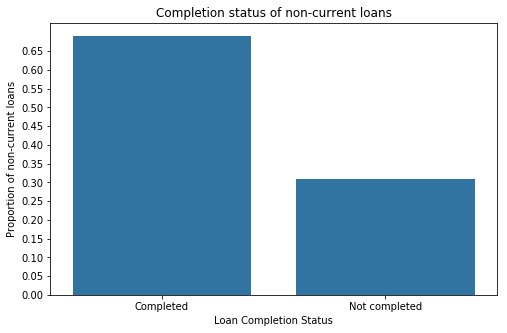

In [6]:
# Plot LoanCompleted column as %
base_color = sb.color_palette()[0]
n_points = loans.shape[0]
max_count = loans['LoanCompleted'].value_counts().max()
max_prop = max_count / n_points
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

plt.figure(figsize=[8, 5])
sb.countplot(data = loans, x = 'LoanCompleted', color = base_color)
plt.yticks(tick_props * n_points, tick_names)
plt.ylabel('Proportion of non-current loans')
plt.xlabel('Loan Completion Status')
plt.title('Completion status of non-current loans')
plt.show();

## Number of Loans by Term

Most of the loans were for a 36-month term (90% of loans). A much smaller amount were for a 60-month term (7%) and the smallest category was the 12-month term loans (3%).

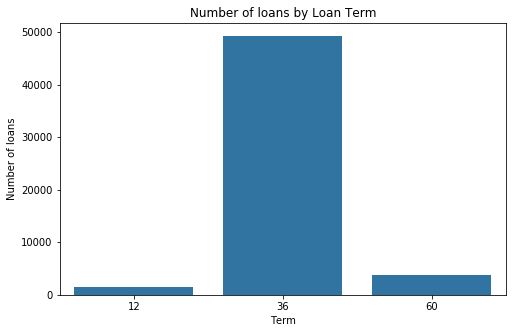

In [7]:
plt.figure(figsize=[8, 5])
sb.countplot(data = loans, x = 'Term', color = base_color)
plt.xlabel('Term')
plt.ylabel('Number of loans')
plt.title('Number of loans by Loan Term')
plt.show();

## Monthly Loan Payments

After a log transformation the Monthly Loan Payments showed a normal distribution. The mean was \\$224 and 75\% were below \\$301. 

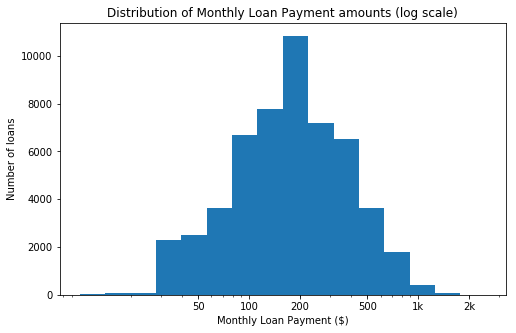

In [8]:
log_binsize = 0.15
bins = 10 ** np.arange(1, np.log10(loans['MonthlyLoanPayment'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans, x = 'MonthlyLoanPayment', bins = bins)
plt.xscale('log')
plt.xticks([50, 100, 200, 500, 1000, 2000], [50, 100, 200, 500, '1k', '2k'])
plt.xlabel('Monthly Loan Payment ($)')
plt.ylabel('Number of loans')
plt.title('Distribution of Monthly Loan Payment amounts (log scale)')

plt.show()

## Debt-to-income Ratios

The mean Debt-to-income ratio was 0.29 and 75% were below 0.3. There was a right skew to the data due to some outliers at a ratio of 10.

In [9]:
# remove outliers before plotting debt-to-income graph
outliers = loans['DebtToIncomeRatio'] > 9.5
without_outliers = loans.loc[-outliers,:]

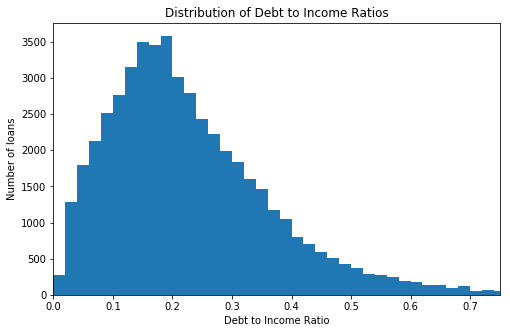

In [10]:
binsize = 0.02
bins = np.arange(0, without_outliers['DebtToIncomeRatio'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = without_outliers, x = 'DebtToIncomeRatio', bins = bins)
plt.xlabel('Debt to Income Ratio')
plt.ylabel('Number of loans')
plt.title('Distribution of Debt to Income Ratios')
plt.xlim(0,0.75)
plt.show()

An analysis of the impact of each of these features on loan completion shows that the dominant level in a feature generally has a loan completion rate close to the mean. For instance, most loans are of a 36-month term and the loan completion rate for these loans is near the 69% average. Where we see some interesting results are with the outliers and levels of features above and below those that are the highest represented. Here we can see where each of these features can have a positive or negative impact on the completion of a loan.

## Loan Completion by Term

The vast majority of loans were for a term of 36-months and therefore the proportion of these loans that were successfully completed was close to the sample mean (69% completed versus 70% for the sample mean). The 60-month loans were slightly worse with a 66% completion rate. 12-month loans were the stand out with a completion rate of 95%. The number of 12-month loans in the data was small but this suggests that a shorter loan term increases the chance of a loan being paid off.

<Figure size 576x360 with 0 Axes>

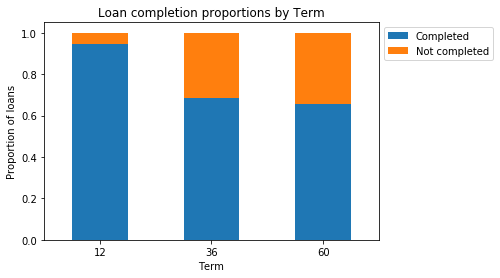

In [31]:
term_props = loans.groupby('Term')['LoanCompleted'].value_counts(normalize=True).unstack()

plt.figure(figsize=[8, 5])
term_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Term', rot=0).legend(
    bbox_to_anchor=(1, 1))
plt.ylabel('Proportion of loans');

## Loan Completion by Debt-to-income Ratio

Loan completion rates were fairly steady up to a debt-to-income ratio of 0.3, which was around 75% of the loans. Above this ratio the loan completion rate began to fall. it bottomed out at 0.7 but after that it never reaches the same level of loan completion as seen at a ratio of 0.3. Higher debt-to-income ratios appear to lower the chance of completing a loan.

In [32]:
# Function to place Debt-To-Income-Ratio into bins
def get_ratio(debt_to_income):
    """Get bin for debt-to-income ratio."""
    if debt_to_income < 0.05:
        return 0.05
    elif debt_to_income < 0.1:
        return 0.1
    elif debt_to_income < 0.15:
        return 0.15
    elif debt_to_income < 0.2:
        return 0.2
    elif debt_to_income < 0.25:
        return 0.25
    elif debt_to_income < 0.3:
        return 0.3
    elif debt_to_income < 0.4:
        return 0.4
    elif debt_to_income < 0.5:
        return 0.5
    elif debt_to_income < 0.6:
        return 0.6
    elif debt_to_income < 0.7:
        return 0.7
    elif debt_to_income < 0.8:
        return 0.8
    elif debt_to_income <0.9:
        return 0.9
    elif debt_to_income < 1:
        return 1
    elif debt_to_income < 3:
        return 3
    elif debt_to_income < 6:
        return 6
    else:
        return 10
    
# Create a column placing Debt-to-income-ratio into a bin
loans['DebtRatioBin'] = loans.DebtToIncomeRatio.apply(get_ratio)

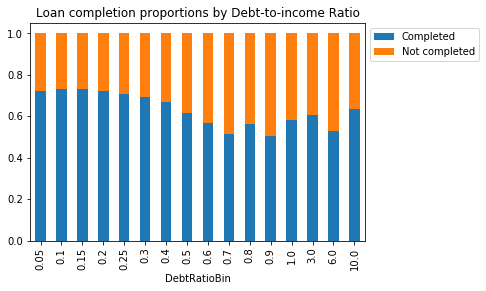

In [33]:
debt_props = loans.groupby('DebtRatioBin')['LoanCompleted'].value_counts(normalize=True).unstack()
debt_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Debt-to-income Ratio').legend(
    bbox_to_anchor=(1, 1));

## Loan Completion by Monthly Loan Payment

The variation in loan completion rate across Monthly Loan Payment amounts was less pronounced. The highest completion rate was at the highest level of monthly payments, however, there were not many loans in these bins. Monthly payments between $750 and $1000 showed the lowest completion rates. Between $50 and $750 there was not a lot of fluctuation either side of the overall mean of 69% and so Monthly Loan Payment value appears to have a smaller impact on loan completion than either loan term or debt-to-income ratio.

In [34]:
# Function to place Monthly Loan Payments into bins
def get_monthly_bin(monthly_payment):
    """Get bin for Monthly Loan Payment."""
    if monthly_payment == 0:
        return 0
    elif monthly_payment < 50:
        return 50
    elif monthly_payment < 100:
        return 100
    elif monthly_payment < 150:
        return 150
    elif monthly_payment < 200:
        return 200
    elif monthly_payment < 250:
        return 250
    elif monthly_payment < 300:
        return 300
    elif monthly_payment < 350:
        return 350
    elif monthly_payment < 400:
        return 400
    elif monthly_payment < 450:
        return 450
    elif monthly_payment < 500:
        return 500
    elif monthly_payment < 550:
        return 550
    elif monthly_payment < 600:
        return 600
    elif monthly_payment < 750:
        return 750
    elif monthly_payment < 1000:
        return 1000
    elif monthly_payment < 1500:
        return 1500
    elif monthly_payment < 2000:
        return 2000
    else:
        return 2500
    
# Create a column placing Debt-to-income-ratio into a bin
loans['MonthlyPaymentBin'] = loans.MonthlyLoanPayment.apply(get_monthly_bin)

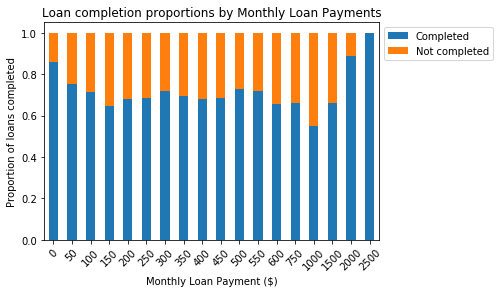

In [39]:
# Compare Loan Outcome Status and Debt Consolidation
monthly_props = loans.groupby('MonthlyPaymentBin')['LoanCompleted'].value_counts(normalize=True).unstack()
monthly_props.plot(kind='bar', stacked='True', title='Loan completion proportions by Monthly Loan Payments', rot=45).legend(
    bbox_to_anchor=(1, 1))
plt.ylabel('Proportion of loans completed')
plt.xlabel('Monthly Loan Payment ($)');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!